In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import math
import gym
from collections import deque
import matplotlib.pyplot as plt

In [14]:
if torch.cuda.is_available():
    d=torch.device("cuda:0")
else:
    d=torch.device("cpu")
env=gym.make('MountainCarContinuous-v0')
env.seed(101)
np.random.seed(101)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [20]:
class Agent(nn.Module):
    def __init__(self,env,h=16):
        super(Agent,self).__init__()
        self.env=env
        self.s=env.observation_space.shape[0]
        self.h=h
        self.a=env.action_space.shape[0]
        self.fc1=nn.Linear(self.s,self.h)
        self.fc2=nn.Linear(self.h,self.a)
        
    def set_w(self,w):
        s=self.s
        h=self.h
        a=self.a
        end=(s*h)+h
        w1=torch.from_numpy(w[:s*h].reshape(s,h))
        b1=torch.from_numpy(w[s*h:end])
        w2=torch.from_numpy(w[end:end+(h*a)].reshape(h,a))
        b2=torch.from_numpy(w[end+(h*a):])
        self.fc1.weight.data.copy_(w1.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(b1.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(w2.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(b2.view_as(self.fc2.bias.data))
    
    def get_weights_dim(self):
        return (self.s+1)*self.h+(self.h+1)*self.a
        
    def forward(self,a):
        a=F.relu(self.fc1(a))
        a=F.tanh(self.fc2(a))
        return a.cpu().data
        
    def evaluate(self,w,g=1.0,t=5000):
        self.set_w(w)
        er=0.0
        state=self.env.reset()
        for t in range(t):
            state=torch.from_numpy(state).float().to(d)
            action=self.forward(state)
            state,r,done,_=self.env.step(action)
            er+=r*math.pow(g,t)
            if done:
                break
        return er
    
agent=Agent(env).to(d)

/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 10	Average Score:-1.44
Episode 20	Average Score:-3.98
Episode 30	Average Score:-4.18
Episode 40	Average Score:2.57
Episode 50	Average Score:18.74
Episode 60	Average Score:29.35
Episode 70	Average Score:38.69
Episode 80	Average Score:45.65
Episode 90	Average Score:47.98
Episode 100	Average Score:52.56
Episode 110	Average Score:62.09
Episode 120	Average Score:72.28
Episode 130	Average Score:82.21
Episode 140	Average Score:89.48

Environment solved in 47 iterations!
Average Score: 90.83


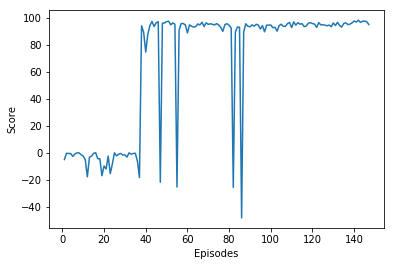

In [21]:
def cem(iterations=500,t=1000,g=1.0,td=10,ps=50,ef=0.2,s=0.5):
    elite=int(ps*ef)
    sd=deque(maxlen=100)
    scores=list()
    bw=s*np.random.randn(agent.get_weights_dim())
    for iter in range(1, iterations+1):
        wp=[bw+(s*np.random.randn(agent.get_weights_dim())) for i in range(ps)]
        reward=np.array([agent.evaluate(weights,g,t) for weights in wp])
        ei=reward.argsort()[-elite:]
        ew=[wp[i] for i in ei]
        bw=np.array(ew).mean(axis=0)
        r=agent.evaluate(bw,g=1.0)
        sd.append(r)
        scores.append(r)
        torch.save(agent.state_dict(),'checkpoint.pth')
        if iter%td==0:
            print('Episode {}\tAverage Score:{:.2f}'.format(iter,np.mean(sd)))
        if np.mean(sd)>=90.0:
            print('\nEnvironment solved in {:d} iterations!\nAverage Score: {:.2f}'.format(iter-100,np.mean(sd)))
            break
    return scores

scores=cem()
fig=plt.figure()
ax=fig.add_subplot(111)
plt.plot(np.arange(1,len(scores)+1),scores)
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.show()

In [23]:
agent.load_state_dict(torch.load('checkpoint.pth'))
state=env.reset()
while True:
    state=torch.from_numpy(state).float().to(d)
    with torch.no_grad():
        action=agent(state)
    env.render()
    ns,r,finished,_=env.step(action)
    state=ns
    if finished:
        break
env.close()

/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
